# Modeling Features

This is a short notebook reproducing in Python what Jim Savage did [here](http://modernstatisticalworkflow.blogspot.ca/2018/03/1000-labels-and-4500-observations-have.html). My humble computer could not handle 5000 data points for 1000 users, so my numbers are lower, but the general effect described by the post persists. 

In [276]:
import seaborn as sns
import pystan
import numpy as np
import pandas as pd
import scipy
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
%matplotlib inline

## Data Generation

In [ ]:
N = 1000
I = 100
A = 30
H = 150
    
def get_data(N, I, A, H):
    alpha = np.random.normal(0, 2, size=(I, A))
    user = np.random.choice(range(I), size=N)
    
    probabilities = scipy.special.expit(alpha[user])
    activities = np.random.binomial(1, probabilities.ravel()).reshape(probabilities.shape)
    
    user_masked = user.copy()
    user_masked[-H:] = -1
    
    return {
        'N': N, 
        'I': I, 
        'A': A, 
        'user': user_masked,
        'activities': activities, 
        'real_user': user
    }

## Random Guess

In [213]:
def accuracy_random(N, I, A, H):
    data = get_data(N, I, A, H)
    return np.mean(data['real_user'][-H:] == np.random.choice(range(I), size=H))

In [214]:
simulations_random = [accuracy_random(N, I, A, H) for i in range(1000)]

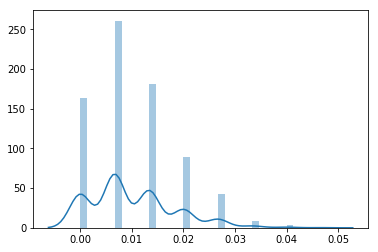

In [215]:
sns.distplot(simulations_random)

## XGBoost

In [267]:
def accuracy_xgboost(N, I, A, H):
    data = get_data(N, I, A, H)
    xg_train = xgb.DMatrix(data['activities'][data['user'] >= 0], label=data['user'][data['user'] >= 0])

    param = {'objective':'multi:softmax',
             'eta': 0.1,
             'max_depth': 6,
             'silent': 1,
             'nthread' :2,
             'num_class': 100}
    
    bst = xgb.train(param, xg_train, 30)
    xg_test = xgb.DMatrix(data['activities'][data['user'] < 0])
    pred = bst.predict(xg_test)
    return np.mean(pred == data['real_user'][-H:])

In [268]:
simulations_xgboost = [accuracy_xgboost(N, I, A, H) for _ in range(100)]

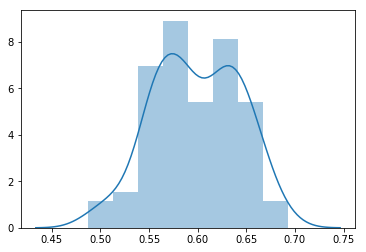

In [269]:
sns.distplot(simulations_xgboost)

## Random Forest

In [196]:
def accuracy_rf(N, I, A, H, n_estimators):
    data = get_data(N, I, A, H)
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(data['activities'][data['user'] >= 0], data['user'][data['user'] >= 0])
    clf_probs = clf.predict_proba(data['activities'][data['user'] < 0])    
    return np.mean(np.argmax(clf_probs, axis=1) == data['real_user'][-H:])

In [220]:
simulations_rf = [accuracy_rf(N, I, A, H, 1000) for _ in range(500)]

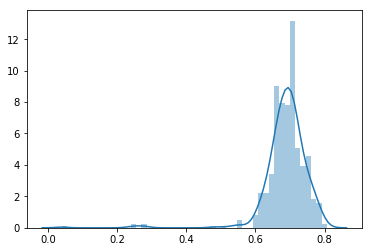

In [221]:
sns.distplot(simulations_rf)

## Generative Model

In [3]:
model_code = '''
data {
  int N; // number of observations
  int I; // number of users
  int A; // number of activities
  
  int user[N]; // user indicator for every observation; -1 if user is missing
  
  matrix[N, A] activities;
}
parameters {
  matrix[I, A] alpha;
}
transformed parameters {
  matrix[N, I] user_probabilities = rep_matrix(0.0, N, I);
  
  for(n in 1:N) {
    // the user is known
    if(user[n] > 0) {
      user_probabilities[n, user[n]] = 1.0;
    } else {
      // the user is unknown
      vector[I] tmp;
      // loop through users
      for(i in 1:I) {
        tmp[i] = log(activities[n] * inv_logit(alpha[i]') + (1.0 - activities[n]) * (1.0 - inv_logit(alpha[i]')));
      }
      user_probabilities[n] = softmax(tmp)';
    }
  }
}
model {
  // Give prior to alpha
  to_vector(alpha) ~ normal(0, 1);
  
  // calculate the log likelihood
  for(n in 1:N) {
    if(user[n] > 0) {
      // log likelihood in the case that we observe the user
      target += activities[n] * log(inv_logit(alpha[user[n]]')) + 
                (1.0 - activities[n]) * log(1.0 - inv_logit(alpha[user[n]]'));
    } else {
      // log likelihood in the case we do not observe the user
      target += log_sum_exp(log(user_probabilities[n]') + // probability of being each user
                            (activities[n] * log(inv_logit(alpha')) + // plus the log likelihood in each state
                            (1.0 - activities[n]) * log((1.0 - inv_logit(alpha'))))');
    } 
  }
}
'''

In [4]:
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_27226d70e9221f52daa7ce0334b89b96 NOW.


In [184]:
def accuracy(N, I, A, H, model):
    data = get_data(N, I, A, H)
    user = data['real_user']
    estimation = model.optimizing(data=data)
    return np.mean(np.argmax(estimation['user_probabilities'][data['user'] < 0 ], axis=1) + 1 == user[-H:])

In [218]:
simulations = [accuracy(N, I, A, H, model) for _ in range(300)]

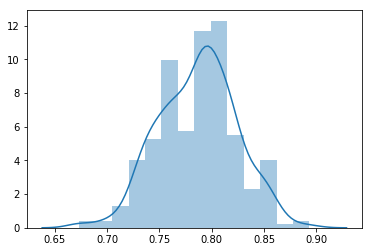

In [219]:
sns.distplot(simulations)